In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [3]:
username = 'alyona_vishnoi'  
password = '******'    
host = 'localhost'            
port = '5432'                 
database = 'score_project'  

connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

engine = create_engine(connection_string)

csv_files = [
    ('../data/events.csv', 'events'),
    ('../data/users.csv', 'users'),
    ('../data/wagers.csv', 'wagers')
]

for csv_file, table_name in csv_files:
    df = pd.read_csv(csv_file)
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    print(f"Loaded {csv_file} into {table_name}.")

Loaded ../data/events.csv into events.
Loaded ../data/users.csv into users.
Loaded ../data/wagers.csv into wagers.


# Part 1: Data Feature Pull

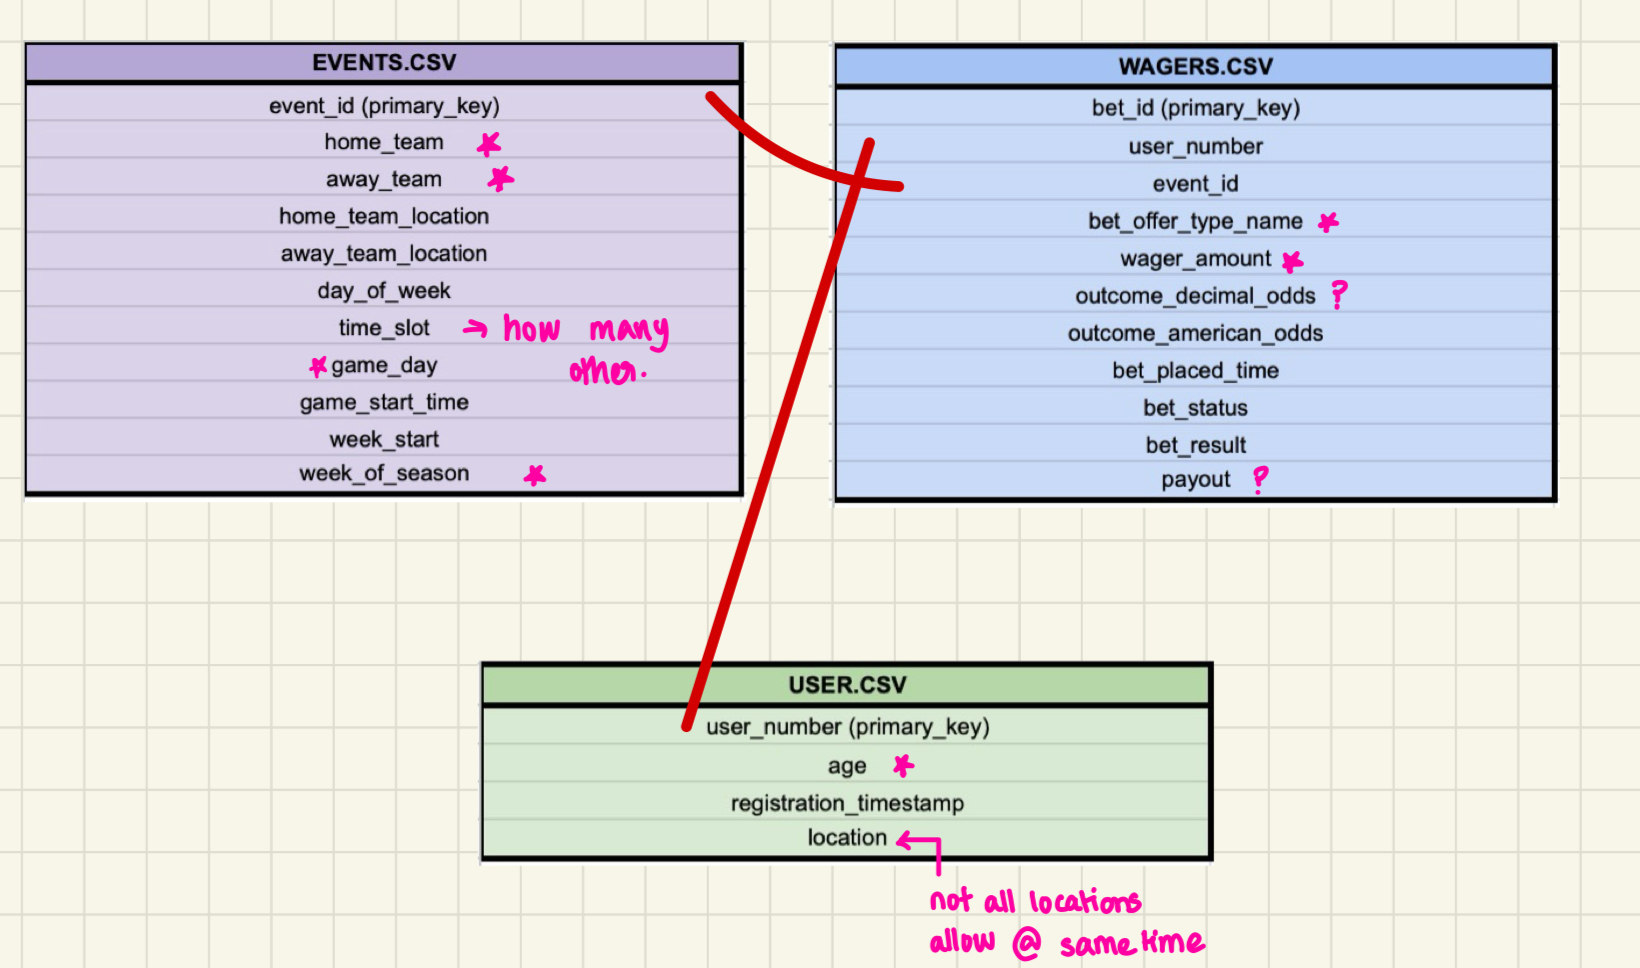

Before diving into the coding, I took the time to visualize the relationships between the tables involved in this project. I drew out the schemas of the wagers, events, and users tables to understand how they interconnected. This high-level overview helped me identify potential features that could enrich my model and clarify the relationships I wanted to explore further.

In [ ]:
# Join the DataFrames (prepare for Feature Engineering)

create_table_query = """
CREATE TABLE final_results AS
SELECT merged_we.*, 
       u.registration_timestamp, u.location
FROM (
    SELECT w.*,
           e.home_team, e.away_team, e.time_slot, e.game_day, e.game_start_time, e.week_of_season
    FROM wagers w
    LEFT JOIN events e ON w.event_id = e.event_id
) AS merged_we
LEFT JOIN users u ON merged_we.user_number = u.user_number;
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_table_query)

#### Feature Engineering: Create New Features

In [ ]:
# 1. Days since registration
create_days_since_registration = """
ALTER TABLE final_results
ADD COLUMN days_since_registration INT;

ALTER TABLE final_results
  ALTER COLUMN registration_timestamp TYPE TIMESTAMP USING registration_timestamp::timestamp,
  ALTER COLUMN game_day TYPE TIMESTAMP USING game_day::timestamp;

-- Calculate days_since_registration
UPDATE final_results
SET days_since_registration = DATE_PART('day', game_day - registration_timestamp);
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_days_since_registration)

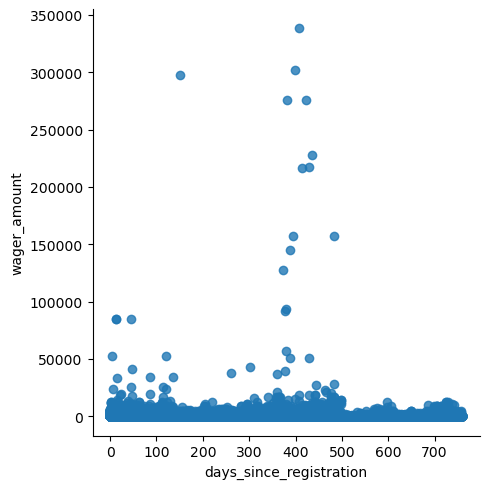

In [11]:
final_results = pd.read_sql("SELECT * FROM final_results;", engine)

sns.lmplot(x='days_since_registration',y='wager_amount',data=final_results)
# Experience (Informed decision) vs amount 

The highest wagers (338,000) were placed in the 300-500 days registration range, indicating that users with moderate experience tend to wager larger amounts.
Interestingly, the 0-100 days range also showed slightly high wagers (80,000), suggesting that new users might initially place substantial bets, possibly driven by promotional incentives or excitement.

**Outliers**: Given the scale of the data, I suspect that both the high wager amounts in the 300-500 days range and the substantial wagers from new users could be outliers. These anomalies could skew the results and might warrant further investigation to understand the underlying factors contributing to such behavior.

**Improvements**: I think implementing methods to detect and treat outliers (e.g., using z-scores or IQR) could have enhanced the reliability of the correlation analysis and yield clearer insights into typical wagering behavior.

In [35]:
# 2. Calculate team popularity
# Different ways:
# - Total wages placed on team
# - Total Bets Placed on a Team
# - Average Wager Amount per Home Team !!!!
# - Checking what teams are playing in later weeks 

create_avg_wager_home_team = """
ALTER TABLE final_results
ADD COLUMN IF NOT EXISTS avg_wager_home_team FLOAT; 

-- Step 1: Calculate the average wager amount per home team
WITH average_wager AS (
    SELECT home_team,
           AVG(wager_amount) AS avg_wager_amount
    FROM final_results
    GROUP BY home_team
)

-- Step 2: Update final_results to include the average wager amount
UPDATE final_results f
SET avg_wager_home_team = a.avg_wager_amount
FROM average_wager a
WHERE f.home_team = a.home_team;
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_avg_wager_home_team)


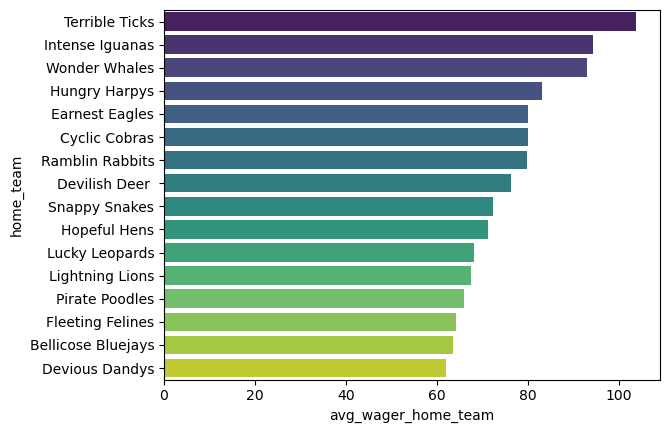

In [44]:
# create a plot for home team and create_avg_wager_home_team
avg_bets_df = pd.read_sql("SELECT DISTINCT home_team, avg_wager_home_team FROM final_results;", engine)

avg_bets_df = avg_bets_df.sort_values(by='avg_wager_home_team', ascending=False)
sns.barplot(x='avg_wager_home_team', y='home_team', data=avg_bets_df, palette='viridis')
plt.show()

The resulting plot reveals distinct differences in wagering behavior across home teams. Notably, the Terrible Ticks had the highest average wager amount, indicating a strong bettor commitment. In contrast, the Devious Dandys exhibited the lowest average wager, suggesting a weaker following or lesser confidence among bettors.

In [ ]:
# 3. Wagering Availability by Province
create_days_since_rollout = """
ALTER TABLE final_results
ADD COLUMN days_since_rollout INT;

-- USE CTE to find the minimum registration timestamp for each location
WITH province_rollout AS (
    SELECT location,
           MIN(registration_timestamp::timestamp) AS registration_rollout
    FROM users
    GROUP BY location
)

-- Step 2: Update the final_results table with the days_since_rollout calculation
UPDATE final_results f
SET days_since_rollout = DATE_PART('day', (u.registration_timestamp::timestamp - pr.registration_rollout))
FROM users u
JOIN province_rollout pr ON u.location = pr.location
WHERE u.user_number = f.user_number;
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_days_since_rollout)

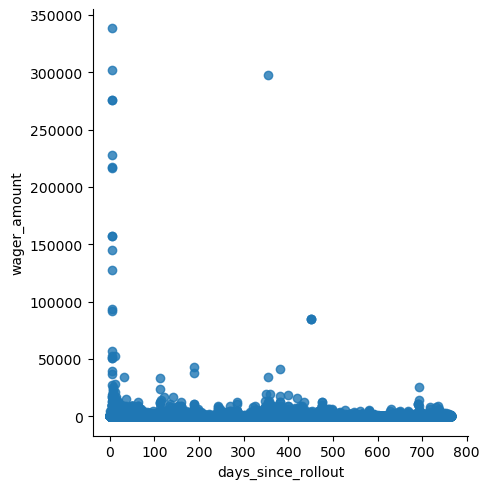

In [48]:
final_results = pd.read_sql("SELECT * FROM final_results;", engine)

sns.lmplot(x='days_since_rollout',y='wager_amount',data=final_results)
plt.show()

Interestingly, the plot reveals that the 0-80 days since rollout period corresponds to high wagering amounts. This could suggest that early adopters in provinces where wagering has recently been introduced are actively engaging with the platform.

In [20]:
# 4. #Bets in Time Slots

create_games_in_time_slots = """
ALTER TABLE final_results
ADD COLUMN game_bets_in_timeslot INT;

-- Step 1: Create a CTE to count the number of bets placed on a game in each time slot for each day
WITH game_bets_in_timeslot AS (
    SELECT game_day,
           time_slot,
           COUNT(*) AS game_bets_in_timeslot
    FROM final_results
    GROUP BY game_day, time_slot
)

-- Step 2: Update final_results table by merging the counts back
UPDATE final_results f
SET game_bets_in_timeslot = g.game_bets_in_timeslot
FROM game_bets_in_timeslot g
WHERE f.game_day = g.game_day AND f.time_slot = g.time_slot;

"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_games_in_time_slots)

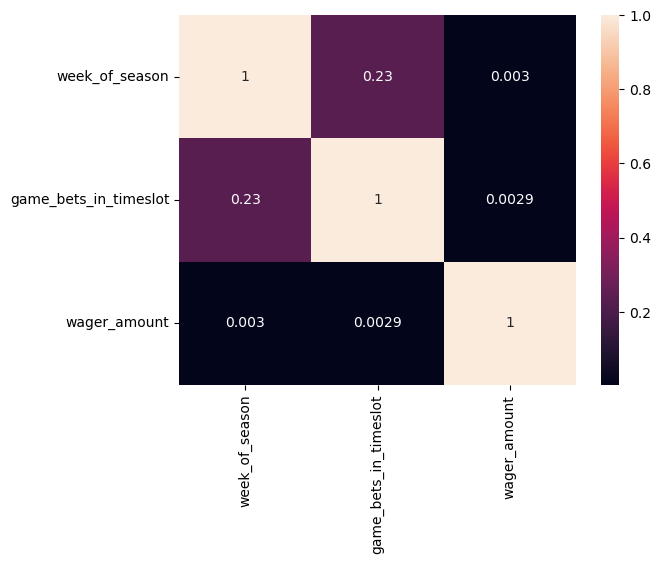

In [49]:
df = pd.read_sql("SELECT week_of_season, game_bets_in_timeslot, wager_amount  FROM final_results;", engine)
correlation = df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.show()

The analysis shows a weak correlation between <code>week_of_season</code> and <code>game_bets_in_timeslot</code>. While the statistical relationship might not be strong, I believe this feature is still significant due to sports knowledge. As teams are eliminated, the remaining games gain more attention, increasing bets in those time slots. This could lead to higher overall wagers, even though the correlation is numerically weak.

In [23]:
# 5. Implied probabilty 
create_implied_probability = """
ALTER TABLE final_results
ADD COLUMN IF NOT EXISTS implied_probability FLOAT;

UPDATE final_results
SET implied_probability = (1.0 / outcome_decimal_odds) * 100;
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_implied_probability)

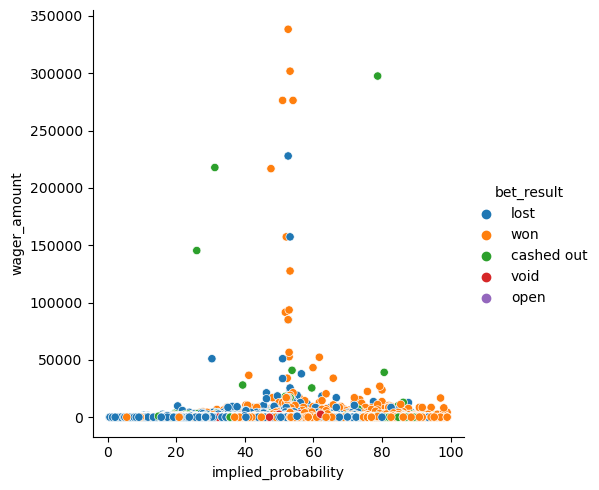

In [50]:
df = pd.read_sql("SELECT implied_probability, wager_amount, bet_result FROM final_results;", engine)
sns.relplot(x="implied_probability", y="wager_amount", hue="bet_result", data=df)
plt.show()

While there was no strong linear relationship between implied probability and wager amount, the cluster around **50%** could indicate that bettors are more confident placing larger wagers on events they perceive as balanced (where either outcome seems equally likely). Additionally, most of the super-high wagers were on winning bets, suggesting that bettors placing large sums may have more accurate insights or access to better information (See below).

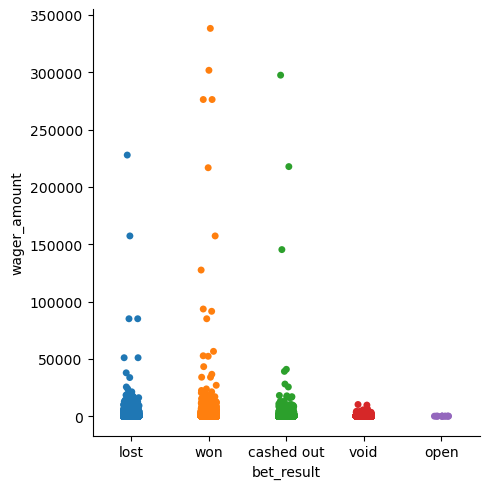

In [47]:
# Further explore, correlation between bet_result and wager_amount
sns.catplot(data=df, x="bet_result", y="wager_amount", hue=None,)
plt.show()

## Problem: Need weekly attributes - week number, total wager in week

In [78]:
create_week_numbers = """
ALTER TABLE final_results
ADD COLUMN week_number INT;

UPDATE final_results
SET week_number = FLOOR(DATE_PART('day', game_day - (SELECT MIN(game_day) FROM final_results)) / 7) + 1;
"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_week_numbers)

In [85]:
create_weekly_wager_total = """
ALTER TABLE final_results
ADD COLUMN weekly_wager_total NUMERIC;

UPDATE final_results
SET weekly_wager_total = subquery.total_wager
FROM (
    SELECT week_number, SUM(wager_amount) AS total_wager
    FROM final_results
    GROUP BY week_number
) AS subquery
WHERE final_results.week_number = subquery.week_number;

"""

# Execute the query
with engine.connect() as connection:
    connection.execute(create_weekly_wager_total)

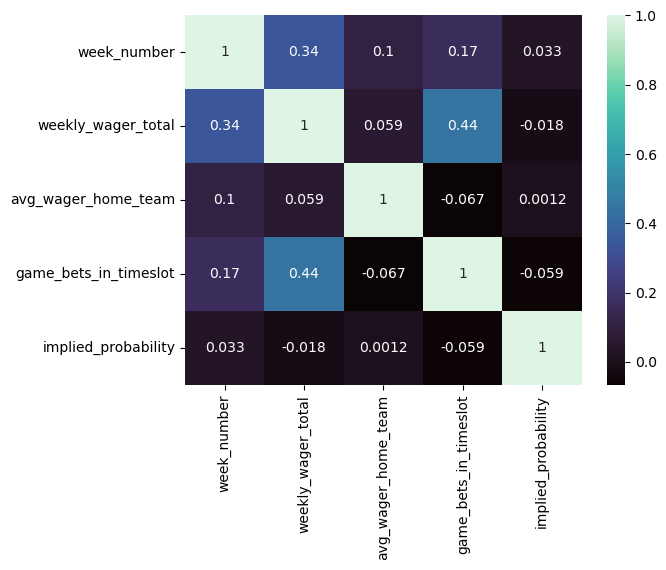

In [106]:
final_df = pd.read_sql("SELECT * FROM final_results;", engine)
features = final_df[[ 'game_day','week_number', 'weekly_wager_total', 'avg_wager_home_team', 'game_bets_in_timeslot', 'implied_probability']]
features = features.sort_values(by='week_number')

correlation = features.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, cmap="mako")
plt.show()

# Part 2: The Model

In [107]:
# Define target and features
X = features.drop('weekly_wager_total', axis=1)  # Features
y = features['weekly_wager_total']  # Target variable

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
from pmdarima import auto_arima

model = auto_arima(y_train, exogenous=X_train, seasonal=False, error_action="ignore", suppress_warnings=True)

In [109]:
model.fit(y_train, exogenous=X_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
n_periods = len(X_test)  # Number of predictions to make (same as the length of X_test)
y_pred = model.predict(n_periods=n_periods, exogenous=X_test)

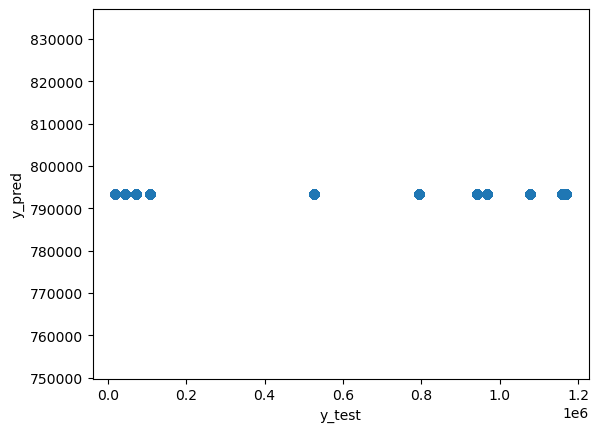

In [113]:
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Write up

The goal of this analysis is to predict the "handle," or the total amount wagered, on Sportsball matches in week 12 of the 2020 season.

---
## Part 1: Feature Engineering
To construct an effective predictive model, I identified several key features:

### Days Since Registration:
I created a new feature called <code>days_since_registration</code> in the final_results table. This feature quantifies the number of days that have passed since a user registered on the platform, calculated as the difference between the event date (<code>game_day</code>) and the registration date (<code>registration_timestamp</code>). 

The rationale behind this feature is to assess the impact of user experience on wagering behavior. Understanding how long users have been registered can provide insights into their familiarity with the platform and potential betting patterns. For example, newer users may exhibit different behaviors compared to long-term users, 
- new users may be more excited to place bets
- experience may play into the amount wagered by the user

### Team Popularity:
I aimed to quantify team popularity using various metrics, focusing on the <code>avg_wager_amount</code> per home team. This feature provides insight into which teams attract more financial commitment from bettors, indicating their popularity.

Other considerations to measure team popularity were:
- **Total wages placed on team:** While this metric provides a clear picture of overall financial commitment, it doesn’t account for the number of bets placed. A team with a few high-stake wagers might appear more popular than it is if the volume of bets is low, leading to a skewed perception of its popularity.
- **Total Bets Placed on a Team:** This metric reflects the engagement level but can be misleading if the average bet size is very low. A team that attracts a high number of low-value bets might not necessarily indicate popularity in terms of financial commitment, which is more relevant for assessing potential revenue.
- **Checking what teams are playing in later weeks:** Analyzing future matchups could provide context for popularity but may introduce speculative elements. Popularity can fluctuate based on various factors, such as team performance and upcoming rivalries, making it challenging to draw definitive conclusions

Ultimately, I decided to focus on the average wager amount per home team since it strikes a balance between financial commitment and user engagement. 

**Limitations of Focusing Solely on Home Teams:**
While I calculated the average wager amount based on the home team, I recognize that this approach may not fully capture the dynamics of team popularity. Bets placed on games often involve both home and away teams. If a high wager is placed on a game featuring a home team, but the bet is actually for the rival away team, this could inaccurately inflate the average wager for the home team. Consequently, the popularity metrics may reflect skewed data.
To improve the accuracy of the popularity metric, I could explore the following alternatives:
- Instead of calculating the average wager amount solely for home teams, I could aggregate wagers at the game level. This would involve determining the total amount wagered for each game, regardless of which team was home or away. Then, I could calculate average wagers for both teams participating in the game. This method would provide a clearer understanding of overall popularity without bias.
- If data were available indicating whether each wager was placed specifically on the home or away team, I could calculate average wager amounts separately for both.


### Wagering Availability by Province:
I aimed to analyze wagering availability by province by calculating the number of days since the rollout of registration in each location (<code>days_since_rollout</code>). This metric helps assess how long users in different provinces have been able to participate in wagering activities. Understanding the time since the rollout of wagering in various provinces is crucial for evaluating user engagement and the potential impact of market entry strategies.

### Number of Bets in Time Slots:
To analyze betting behaviors across different time slots, I created a new feature, <code>game_bets_in_timeslot</code>. This metric captures the total number of bets placed on games during specific time slots on each game day. 

I also analyzed the week of the season; and I noticed that as the season progresses, there are typically fewer games, leading to more bets placed in the **same** time slot. Earlier in the season, there are more games, potentially resulting in fewer bets on any single game.


However, after further reflection and considering the problem statement—predicting the total amount wagered—I realized that the time slot-based feature might not be the most informative tool for this specific task.

**Alternative Approach: Focus on Later Weeks in the Season**
Given that the task is to predict the total wagered amount, a more impactful feature could have been related to the stage of the season. In later weeks, when fewer teams remain in contention, there may be increased attention and potentially higher wager amounts, as focus shifts to key matchups. Games towards the end of the season may attract more significant bets due to their high stakes.
Instead of focusing on time slots, I could have explored:
- **Weeks Remaining in the Season:** An indicator of how late the game is in the season. The idea is that as the season progresses and there are fewer games, bettors may place larger wagers on key teams and games.
- **Total Bets in Each Week:** Instead of looking at individual time slots, counting the total number of bets placed in a specific week might provide better insights into overall wagering trends as the season progresses.

### Implied Probability:
The purpose of this feature is to gauge how betting behavior changes based on the likelihood of an outcome. Bettors may wager more confidently when an outcome has a higher implied probability, which could directly influence the wager amounts. By incorporating this feature, I aimed to analyze whether higher implied probabilities lead to higher wager amounts.

**Limitation**:
This approach assumes that higher implied probability leads to higher wager amounts. However, some bettors might prefer betting on long-shot outcomes with lower probabilities in hopes of higher payouts, which could create a non-linear relationship between wager amount and implied probability.

**Additional Consideration:**
A potential improvement could have been segmenting bets based on odds ranges, for example, grouping high-probability bets (favorites) versus low-probability bets (underdogs). This segmentation would give more insight into how different types of bettors approach high and low probability scenarios. Another improvement would be to combine this feature with bettor profiles to understand whether certain users are more likely to bet on higher-probability outcomes.

---
## Reflecting on feature engineering
As I progressed through the project, I realized I had spent a considerable amount of time perfecting features at the **user level**. While these features provided valuable insights into individual betting behavior, the ultimate task was to **predict the total amount wagered in a future week**. This realization prompted me to take a step back and reassess my approach. I needed to pivot from a granular user-level focus to a more holistic, week-level perspective.

#### What I Did:
I initially created some weekly attributes based on the user-level data, assuming I could aggregate the final predictions from individual users. Two of the engineered features were:
- **Week Number:** This feature calculated the week number of each game relative to the earliest game in the dataset. The assumption was that I could track wager patterns on a weekly basis and then use this information to make predictions.
- **Weekly Wager Total:** After determining the week number, I calculated the total wager amount for each week. This gave me an aggregated metric that I planned to use for predictive modeling.

#### Why:
I decided to engineer these weekly features because they aligned better with the problem statement — predicting total wagers for an upcoming week. The key here was to move away from just focusing on individual user behavior and instead aggregate the insights into a week-level perspective that could be more predictive for total wagers.

#### Limitations & Reflective Thought:
While this was a step in the right direction, my approach still focused heavily on aggregating user-level data to form the weekly predictions. In hindsight, this presented some limitations:
- **Data Granularity:** By relying on user-level data for weekly predictions, I introduced complexity that may not have been necessary. A more straightforward approach could have been to aggregate the data upfront at the week level, creating more generalized features like average wagers per week or total wagers per game in each week.
- **Modeling Approach:** I initially assumed that predictions would be made based on user-level data, but this wasn't explicitly required by the problem. By focusing too much on user-level attributes, I risked overlooking week-level trends that would have been more effective predictors.

#### Alternative Approach:
If I could revisit this part of the project, I would explore aggregating data to a higher level early on, possibly focusing on game-level or week-level features.
- For example, instead of calculating features per user, I could have created attributes for each game, like total wagers per game and then aggregated that on a weekly basis.

---
In the end, I refocused my approach with the problem statement in mind and selected features that I believed would be the most predictive of the total amount wagered on a weekly basis. The final feature set included:
- <code>game_day</code>
- <code>week_number</code>
- <code>weekly_wager_total</code>
- <code>avg_wager_home_team</code>
- <code>game_bets_in_timeslot</code>
- <code>implied_probability</code>

I pulled these features from the dataset and sorted them by week_number to maintain a structured, chronological order.

---
## Part 2: The Model

#### Model Selection: Why I Chose ARIMA
For this problem, I opted for an ARIMA (AutoRegressive Integrated Moving Average) model, which is widely used in time series forecasting. I considered ARIMA because of its ability to handle time-dependent data, making it an excellent choice for predicting outcomes over a series of weeks. The problem required predicting total weekly wager amounts, and ARIMA excels in capturing the relationship between time-lagged variables, which seemed like a natural fit given that betting behavior is likely to exhibit temporal patterns. Additionally, the flexibility of ARIMA allows for incorporating exogenous variables (such as the features I engineered like game bets in timeslot and implied probability), which further informed my decision.

Positives of ARIMA:
- **Time Dependency:** The model can account for trends in time-series data.
- **Incorporation of Exogenous Variables:** It allowed me to use relevant features, capturing external influences beyond just the weekly totals.

#### Considered Alternatives and Why I Didn’t Choose Them
- **Linear Regression:** While this model is straightforward and interpretable, I believed that it would fail to capture the time-series nature of the problem. Linear regression assumes independence between data points, which is not true for this case since weekly wager totals are likely to be influenced by previous weeks.

- **Random Forest Regression:** This model is powerful for complex, non-linear problems, but it doesn’t account for the temporal dependencies between data points in time series. While I initially considered it for its robustness in handling a wide range of features, I ruled it out because the primary challenge was predicting future totals based on the sequence of previous weeks rather than just user-level data.

- **Gradient Boosting Regressor (GBR):** GBR could have been a good option for capturing more complex relationships. However, similar to Random Forest, GBR lacks the ability to account for time dependencies in its standard form. I also thought that, given the structured nature of the data (weekly totals), a simpler model like ARIMA would be more appropriate. Additionally, I wanted to avoid overfitting, which is sometimes a concern with boosting methods when the target variable is time-related.

#### What Happened with My Model
When I fit the ARIMA model, it ended up choosing parameters of (0, 1, 0), which means it modeled the data based purely on differences between successive time points without any auto-regressive or moving average components. I think this oversimplification stemmed from the fact that I applied it to user-level data, which perhaps wasn’t the most ideal structure for a model designed to capture aggregate trends over time.

The scatter plot of actual vs predicted values shows that the predictions stayed largely within a narrow range, suggesting that the model didn’t pick up on the variability in the wager amounts. This could be because I didn’t have enough variation at the aggregate level due to the way I structured my data.

#### How Do I Feel About the Results?
Reflecting on the model's performance, it's clear that ARIMA didn’t capture the complexity of the problem as well as I had hoped. While it did provide some insights, it fell short of predicting the total wagers accurately, as evidenced by the flatness of the predictions. I think this comes from the fact that I was working with user-level data for a problem that was looking for weekly totals. The model didn’t fully leverage the time-series nature of the data, potentially because the features I engineered weren't aggregated appropriately for the weekly level.

#### Improvements for Future Iterations
Aggregate Weekly Features: Next time, I would shift my focus more on aggregating features at a weekly level rather than keeping things on a user level. That would make it easier to capture trends across weeks, rather than noise from individual users.

---
## Challenges and Limitations
One of the main challenges I encountered was related to the **structure of the dataset**. Since I initially focused on user-level data, it didn’t translate well when I tried to model aggregate weekly wager totals. The lack of variability in some of my engineered features might have also limited the model’s ability to make accurate predictions. Additionally, while I had some really useful exogenous variables, there may have been other influential factors I wasn’t able to capture.

--- 
## Conclusion: A Fun and Insightful Challenge
Overall, this case was both fun and challenging. I thoroughly enjoyed diving into the data, engineering thoughtful features, and working through the different modeling decisions. While the results weren’t perfect, the process helped me better understand the nuances of sports betting data and the complexities involved in predictive modeling. I look forward to applying these learnings in future projects, and I’m confident that with some adjustments, I could build a more effective solution next time around!